In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=1)
sns.set_style('ticks',{'axes.grid' : False})

In [3]:
D = pd.read_csv('/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/denovo_clustering/logs.csv')
X_mean = D.groupby('n_components').mean()[['bic']]
X_sd = D.groupby('n_components').std()[['bic']]
best_n_components = X_mean['bic'].idxmin()

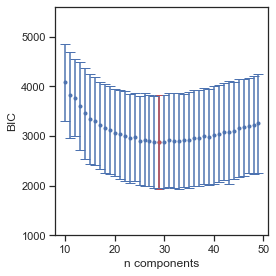

In [4]:
save_pth = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/Patchseq_Bioarxiv_2019/'
plt.figure(figsize=(4,4))
plt.errorbar(x=X_mean.index.values,
             y=X_mean['bic'].values,
             yerr=X_sd['bic'].values,
             fmt='.',
             capsize=5)

plt.errorbar(x=best_n_components,
             y=X_mean['bic'][best_n_components],
             yerr=X_sd['bic'][best_n_components],
             fmt='.',
             c='r',
             capsize=3)

ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.tight_layout()
plt.savefig(save_pth+'denovo_gmm_bic.png',dpi=300)

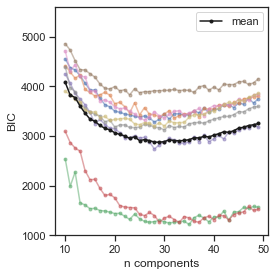

In [8]:
n_component_list=[]
plt.figure(figsize=(4,4))
for cv in range(9):
    Dd = D[D['cv']==cv]
    plt.plot(Dd['n_components'],Dd['bic'],'.-',alpha=0.5)
    temp = Dd.loc[Dd['bic']==Dd['bic'].min()]
    n_component_list.append(temp['n_components'].values[0])
plt.plot(X_mean.index.values,X_mean['bic'].values,'.-',c='k',label='mean')
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.legend()
plt.tight_layout()
plt.savefig(save_pth+'denovo_gmm_bic_individual.png',dpi=300)

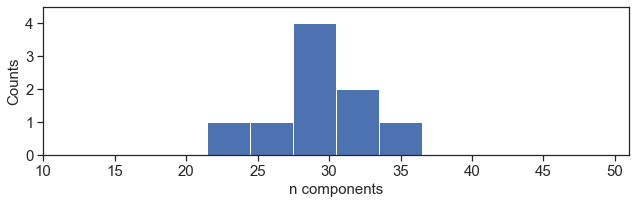

In [10]:
yy = n_component_list
plt.figure(figsize=(9,3))
plt.hist(yy,bins=np.arange(12,50,3)+0.5)
ax = plt.gca()
ax.set_xlabel('n components',fontsize=15)
ax.set_ylabel('Counts',fontsize=15)
ax.set_ylim(0,4.5)
ax.set_xlim(10,51)
ax.set_yticks(np.arange(0,4.5,1))
ax.set_yticklabels(np.arange(0,4.5,1).astype(int),fontsize=15)
ax.set_xticks(np.arange(10,51,5))
ax.set_xticklabels(np.arange(10,51,5).astype(int),fontsize=15)
plt.tight_layout()
plt.savefig(save_pth+'denovo_gmm_bic_best_n_component_counts.png',dpi=300)
plt.show()

In [11]:
def confusion(a,b,unique_a,unique_b):
    """
    `a`, `b` : numpy arrays of labels for all the element.
    `unique_a`, `unique_b` : unique list of labels. Can have more entries than np.unique(a) and np.unique(b) 
    """xt
    assert a.shape==b.shape
    C = np.zeros((np.size(unique_a),np.size(unique_b)))
    for i,la in enumerate(unique_a):
        for j,lb in enumerate(unique_b):
            C[i,j] = np.sum(np.logical_and(a==la,b==lb))
    return C

In [3]:
# load fitted gmm model from file
from analysis_denovo_script import set_paths
from sklearn import mixture
import scipy.io as sio
import pickle 

dir_pth = set_paths(exp_name='denovo_clustering')

#Representations
alpha_T=1.0
alpha_E=1.0
alpha_M=1.0
lambda_TE=1.0
fiton='zT'
n_cvfolds = 9

#Load all CV sets 
X_train = []
XT = []
XE = []
for cvfold in range(9):
    cvfold_fname='v2_aT_'+str(alpha_T)+\
                '_aE_'+str(alpha_E)+\
                '_aM_'+str(alpha_M)+\
                '_cs_'+str(lambda_TE)+\
                '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cvfold)+\
                '_ri_0500_ft-summary'
    cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
    CV = sio.loadmat(dir_pth['cvfolds']+cvfold_fname,squeeze_me=True)
    X_train.append(CV[fiton][CV['train_ind'],:])

    XT.append(CV['zT'])
    XE.append(CV['zE'])

bic = []
true_labels = []
pred_labels = []
C = []
best_n_components = 30
for cv in range(0,n_cvfolds):
    fname = 'gmm_{}_comp_{}_cv.pkl'.format(best_n_components,cv)
    with open(dir_pth['result']+fname, 'rb') as fid:
        gmm = pickle.load(fid)
    
    bic.append(gmm.bic(X_train[cv]))
    
    #Test cross modal consistency:
    true_labels.append(gmm.predict(XT[cv]))
    pred_labels.append(gmm.predict(XE[cv]))
#     C.append(confusion(a=true_labels[cv],
#                         b=pred_labels[cv],
#                         unique_a=np.arange(best_n_components),
#                         unique_b=np.arange(best_n_components)))
    
print('Avg {} component model BIC over cvfolds: {:.2f}'.format(best_n_components,np.mean(bic)))

Avg 30 component model BIC over cvfolds: 2884.35


/Users/fruity/miniconda3/envs/tf21-cpu/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/fruity/miniconda3/envs/tf21-cpu/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/fruity/miniconda3/envs/tf21-cpu/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.22 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/fruity/miniconda3/envs/tf21-cpu/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GaussianMixture from versio

In [8]:
%matplotlib inline

**Confusion matrix (normalized) for the best CV fold**

In [9]:
from scipy.cluster import hierarchy
cv=3

cvfold_fname='v2_aT_'+str(alpha_T)+\
            '_aE_'+str(alpha_E)+\
            '_aM_'+str(alpha_M)+\
            '_cs_'+str(lambda_TE)+\
            '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+\
            '_ri_0500_ft-summary'
cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
CV = sio.loadmat(dir_pth['cvfolds']+cvfold_fname,squeeze_me=True)

In [10]:
test_ind = np.concatenate([CV['val_ind'],CV['test_ind']])

In [11]:
#Normalize confusion matrix
true_labels = true_labels[cv][test_ind]
pred_labels = pred_labels[cv][test_ind]
C = confusion(a=true_labels,
              b=pred_labels,
              unique_a=np.arange(best_n_components),
              unique_b=np.arange(best_n_components))

C_rowsums = np.expand_dims(np.sum(C,axis=1),axis=-1)
Cnorm = np.divide(C,C_rowsums+0.001)

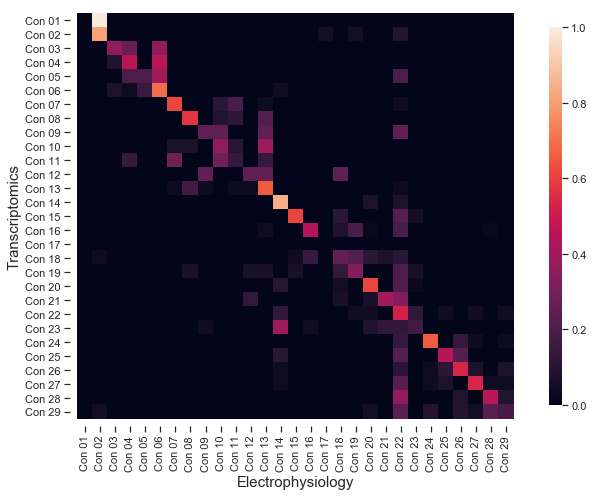

In [12]:
#Group rows together based on similarity
D = hierarchy.distance.pdist(Cnorm)
Z = hierarchy.ward(D)
ordr = hierarchy.leaves_list(Z)

#Reorder Mnorm and cluster labels
Cnorm_ordered = Cnorm[np.ix_(ordr,ordr)]

unique_con_labels = ['Con {:02d}'.format(c+1) for c in np.arange(best_n_components)]

plt.figure(figsize=(9,7))
ax = sns.heatmap(Cnorm_ordered,vmin=0,vmax=1,cbar_kws={"aspect":30,"shrink":.9})

ax.set_yticks(np.arange(best_n_components)+0.5)
ax.set_yticklabels(unique_con_labels,rotation=0)

ax.set_xticks(np.arange(best_n_components)+0.5)
ax.set_xticklabels(unique_con_labels,rotation=90)

ax.set_xlabel(r'Electrophysiology',fontsize=15)
ax.set_ylabel(r'Transcriptomics',fontsize=15)

ax.set_xlim(-0.5, best_n_components+0.5)
ax.set_ylim(best_n_components+0.5, -0.5)

plt.tight_layout()

plt.savefig(save_pth+'denovo_confusion_matrix.png',dpi=300)
plt.show()

**Comparison of consensus clusters with t-type labels**

In [13]:
con_true_labels = np.empty(shape=true_labels.shape,dtype=object)
con_pred_labels = np.empty(shape=pred_labels.shape,dtype=object)
for i,oo in enumerate(ordr):
    con_true_labels[true_labels==oo]='Con {:02d}'.format(i+1)
    con_pred_labels[pred_labels==oo]='Con {:02d}'.format(i+1)
ordr

array([ 2, 17,  3,  8,  5, 22, 20,  6, 12,  1, 14, 13, 25, 15, 21, 19, 26,
        4, 24, 18,  9,  7, 28,  0, 10, 23, 27, 11, 16], dtype=int32)

In [14]:
for ll in sorted(set(zip(con_pred_labels,pred_labels))):
    print(list(ll))

['Con 02', 17]
['Con 03', 3]
['Con 04', 8]
['Con 05', 5]
['Con 06', 22]
['Con 07', 20]
['Con 08', 6]
['Con 09', 12]
['Con 10', 1]
['Con 11', 14]
['Con 12', 13]
['Con 13', 25]
['Con 14', 15]
['Con 15', 21]
['Con 16', 19]
['Con 17', 26]
['Con 18', 4]
['Con 19', 24]
['Con 20', 18]
['Con 21', 9]
['Con 22', 7]
['Con 23', 28]
['Con 24', 0]
['Con 25', 10]
['Con 26', 23]
['Con 27', 27]
['Con 28', 11]
['Con 29', 16]


**Load t-types**

In [15]:
from analysis_tree_helpers import HTree, Node, get_valid_classifications,do_merges
import scipy.io as sio
import pandas as pd
%matplotlib inline

O = sio.loadmat(dir_pth['data']+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)
htree_df = pd.read_csv(dir_pth['data']+'dend_RData_Tree_20181220_pruned.csv')
htree = HTree(htree_df=htree_df)

#Order t-types based on htree:
t_types = []
x = []
for l in np.unique(O['cluster']):
    x.append(htree.x[htree.child==l][0])
    t_types.append(l)
ind = np.argsort(np.array(x))
t_types = np.array(t_types)
t_types = t_types[ind]

**If want merged labels from Tasic hierarchy**

In [16]:
# list_changes = htree.get_mergeseq()

# for m in range(1,40):
#     orig_labels = O['cluster'].copy()
#     new_labels = do_merges(orig_labels, list_changes=list_changes, n_merges=m)
#     if np.unique(new_labels).size==best_n_components:
#         print('n_merges = {} for {} clusters'.format(m,best_n_components))
#         break
        
# orig_labels = O['cluster'].copy()
# T_merged_labels = do_merges(orig_labels, list_changes=list_changes, n_merges=20)

# htree.plot((15,5),fontsize=12,skeletoncol='#000000',ls='-',txtleafonly=True)
# ax = plt.gca()
# ax.set_xlim(30,95)
# ax.axis('off')

# for l in np.unique(new_labels):
#     plt.plot(htree.x[htree.child==l],htree.y[htree.child==l],marker='.',markersize=10,c='#FF0000')
# plt.tight_layout()

In [ ]:
def set_ME_labels(O):
    import scipy.io as sio
    import pandas as pd

    dir_pth = {}
    #/allen/programs/celltypes/workgroups/ivscc/nathang/me_clust_output/inh_met_mouse_me_clustering/refined_text_labels.csv
    dir_pth['data'] = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
    ME = pd.read_csv(dir_pth['data']+'refined_text_labels.csv')
    ME.columns = ['spec_id_label','cluster']
    MEdict = {'spec_id_label':ME['spec_id_label'].values,'cluster':ME['cluster'].values}

    ind = np.isin(O['E_spec_id_label'],MEdict['spec_id_label'])
    print('{:d} cells have ME labels'.format(np.sum(ind)))
    O['ME_cluster'] = np.array(['NA']*np.size(O['E_spec_id_label']),dtype='object')
    for e in O['E_spec_id_label']:
        set_ind = (MEdict['spec_id_label']==e)
        if np.sum(set_ind)==1:
            O['ME_cluster'][O['E_spec_id_label']==e] = MEdict['cluster'][set_ind]
    return O

In [17]:
%matplotlib inline

In [18]:
from scipy.optimize import linear_sum_assignment

CT = confusion(a=O['cluster'].copy()[test_ind],
               b=con_true_labels,
               unique_a=t_types,
               unique_b=unique_con_labels)

row_ind,col_ind = linear_sum_assignment(-CT)
unique_con_labels = np.array(unique_con_labels)

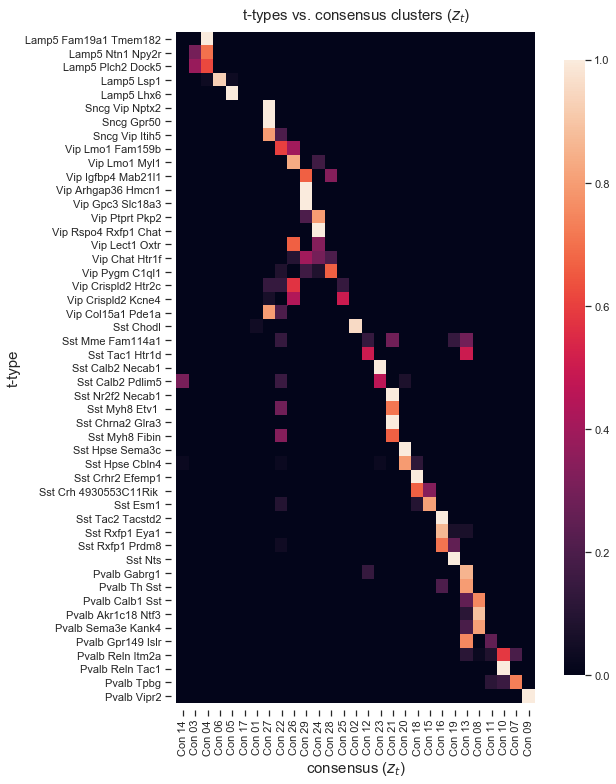

In [19]:
CT = CT[:,col_ind].astype(float)
CT_rowsums = np.expand_dims(np.sum(CT,axis=1),axis=-1)
CTnorm = np.divide(CT,CT_rowsums)

plt.figure(figsize=(9,11))
ax = sns.heatmap(CTnorm,vmin=0,vmax=1,cbar_kws={"aspect":30,"shrink":.9})
ax.set_title(r't-types vs. consensus clusters ($z_t$)',fontsize=15)

ax.set_yticks(np.arange(t_types.size)+0.5)
ax.set_yticklabels(t_types,rotation=0)

ax.set_xticks(np.arange(unique_con_labels.size)+0.5)
ax.set_xticklabels(unique_con_labels[col_ind],rotation=90)

ax.set_ylabel('t-type',fontsize=15)
ax.set_xlabel(r'consensus ($z_t$)',fontsize=15)

ax.set_xlim(-0.5, unique_con_labels.size+0.5)
ax.set_ylim(t_types.size+0.5, -0.5)

plt.tight_layout()

plt.savefig(save_pth+'denovo_ttype_consensus_zt.png',dpi=300)

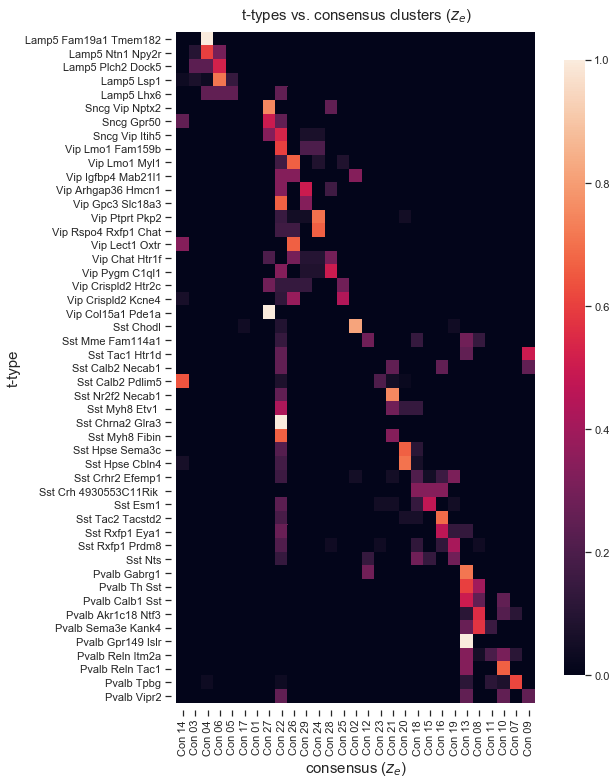

In [20]:
CT = confusion(a=O['cluster'].copy()[test_ind],
               b=con_pred_labels,
               unique_a=t_types,
               unique_b=unique_con_labels)

CT = CT[:,col_ind].astype(float)
CT_rowsums = np.expand_dims(np.sum(CT,axis=1),axis=-1)
CTnorm = np.divide(CT,CT_rowsums)

plt.figure(figsize=(9,11))
ax = sns.heatmap(CTnorm,vmin=0,vmax=1,cbar_kws={"aspect":30,"shrink":.9})
ax.set_title(r't-types vs. consensus clusters ($z_e$)',fontsize=15)

ax.set_yticks(np.arange(t_types.size)+0.5)
ax.set_yticklabels(t_types,rotation=0)

ax.set_xticks(np.arange(unique_con_labels.size)+0.5)
ax.set_xticklabels(unique_con_labels[col_ind],rotation=90)

ax.set_ylabel('t-type',fontsize=15)
ax.set_xlabel(r'consensus ($z_e$)',fontsize=15)

ax.set_xlim(-0.5, unique_con_labels.size+0.5)
ax.set_ylim(t_types.size+0.5, -0.5)

plt.tight_layout()

plt.savefig(save_pth+'denovo_ttype_consensus_ze.png',dpi=300)

In [25]:
from scipy.cluster import hierarchy
cv=3

#Normalize confusion matrix
true_labels = true_labels[cv][test_ind]
pred_labels = pred_labels[cv][test_ind]
C = confusion(a=true_labels,
          b=pred_labels,
          unique_a=np.arange(best_n_components),
          unique_b=np.arange(best_n_components))

C_rowsums = np.expand_dims(np.sum(C,axis=1),axis=-1)
Cnorm = np.divide(C,C_rowsums+0.001)

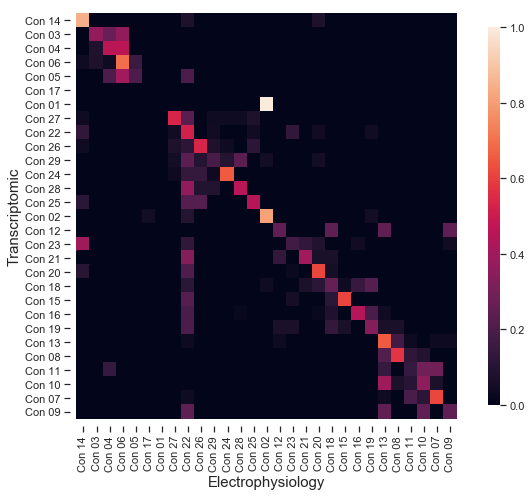

In [26]:
#Group rows together based on similarity
D = hierarchy.distance.pdist(Cnorm)
Z = hierarchy.ward(D)
ordr = hierarchy.leaves_list(Z)

#Reorder Mnorm and cluster labels
Cnorm_ordered = Cnorm[np.ix_(ordr,ordr)]

Cnorm_ordered=Cnorm_ordered[np.ix_(col_ind,col_ind)]

unique_con_labels = np.array(['Con {:02d}'.format(c+1) for c in np.arange(best_n_components)])

plt.figure(figsize=(8,7))
ax = sns.heatmap(Cnorm_ordered,vmin=0,vmax=1,cbar_kws={"aspect":30,"shrink":.9})

ax.set_yticks(np.arange(best_n_components)+0.5)
ax.set_yticklabels(unique_con_labels[col_ind],rotation=0)

ax.set_xticks(np.arange(best_n_components)+0.5)
ax.set_xticklabels(unique_con_labels[col_ind],rotation=90)

ax.set_xlabel(r'Electrophysiology',fontsize=15)
ax.set_ylabel(r'Transcriptomic',fontsize=15)

ax.set_xlim(-0.5, best_n_components+0.5)
ax.set_ylim(best_n_components+0.5, -0.5)

plt.tight_layout()

plt.savefig(save_pth+'denovo_confusion_matrix_reordered.png',dpi=300)
plt.show()

In [8]:
#Unusual python behavior:
X = np.random.rand(10,10)
Xnorm = np.divide(X,np.expand_dims(np.sum(X,axis=1),-1))
print(np.sum(Xnorm,axis=1)==1.0)
#--> use: np.allclose

[False False  True False False False  True False False  True]


In [2]:
list(zip(range(10,46,5),range(15,51,5)))

[(10, 15),
 (15, 20),
 (20, 25),
 (25, 30),
 (30, 35),
 (35, 40),
 (40, 45),
 (45, 50)]

**Using concatenated representations for consistent cluster estimates**

In [9]:
path_ = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/denovo_clustering_zE_zT/'
D = []
for (i,j) in zip(range(10,46,5),range(15,51,5)):
     D.append(pd.read_csv(path_+'logs_{}_{}.csv'.format(i,j)))

D = pd.concat(D)
D = D[D['cv'].isin([0,1,2,3,4])].reset_index(drop=True)

   n_components  cv           bic           aic  converged
1            11   0  34625.794511  33933.289007          1
    n_components  cv           bic           aic  converged
30            15   1  34031.373336  33084.316667          1
    n_components  cv           bic           aic  converged
14            14   2  35000.836888  34116.754433          1
    n_components  cv           bic          aic  converged
15            10   3  34751.014981  34121.15961          1
    n_components  cv           bic          aic  converged
23            13   4  34592.817873  33771.97679          1


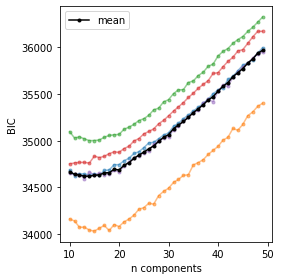

In [14]:
X_mean = D.groupby('n_components').mean()[['bic']]
X_sd = D.groupby('n_components').std()[['bic']]
best_n_components = X_mean['bic'].idxmin()
plt.figure(figsize=(4,4))

for cv in range(5):
    Dd = D[D['cv']==cv]
    plt.plot(Dd['n_components'],Dd['bic'],'.-',alpha=0.5)
    print(Dd.loc[Dd['bic']==Dd['bic'].min()])

plt.plot(X_mean.index.values,X_mean['bic'].values,'.-',c='k',label='mean')
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
#ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.legend()
plt.tight_layout()

**Analysis of uncoupled T representations from Patchseq**

In [1]:
%matplotlib qt5

In [2]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=1)
sns.set_style('ticks',{'axes.grid' : False})

In [4]:
Db = pd.read_csv('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/denovo_clustering_uncoupled/logs_10_30.csv')
Da = pd.read_csv('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/denovo_clustering_uncoupled/logs_31_49.csv')
D = pd.concat([Db,Da])

In [5]:
D

,n_components,cv,bic,aic,converged
0,10,0,16336.068272,15775.716954,1
1,10,1,15923.524437,15362.893589,1
2,10,2,16436.601389,15875.552721,1
3,10,3,16307.037394,15745.803594,1
4,10,4,16433.807913,15872.481675,1
...,...,...,...,...,...
157,48,4,17130.478069,14414.566273,1
158,48,5,17078.729658,14362.817862,1
159,48,6,17073.315009,14355.841134,1
160,48,7,17101.403176,14382.816641,1


In [6]:
X_mean = D.groupby('n_components').mean()[['bic']]
X_sd = D.groupby('n_components').std()[['bic']]
best_n_components = X_mean['bic'].idxmin()

    n_components  cv           bic           aic  converged
72            18   0  16172.500992  15159.340529          1
    n_components  cv           bic           aic  converged
64            17   1  15776.867231  14819.830734          1
     n_components  cv           bic           aic  converged
101            21   2  16286.706431  15102.270355          1
    n_components  cv          bic           aic  converged
57            16   3  16200.40846  15299.032963          1
    n_components  cv           bic           aic  converged
49            15   4  16213.992885  15369.168548          1
    n_components  cv           bic          aic  converged
86            19   5  16167.320887  15095.69807          1
    n_components  cv          bic           aic  converged
51            15   6  16093.21173  15247.901485          1
    n_components  cv           bic           aic  converged
70            17   7  16233.931941  15274.764667          1
    n_components  cv           bic          

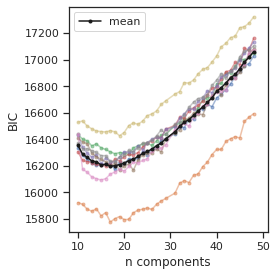

In [7]:
plt.figure(figsize=(4,4))
for cv in range(9):
    Dd = D[D['cv']==cv]
    plt.plot(Dd['n_components'],Dd['bic'],'.-',alpha=0.5)
    print(Dd.loc[Dd['bic']==Dd['bic'].min()])
plt.plot(X_mean.index.values,X_mean['bic'].values,'.-',c='k',label='mean')
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
#ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.legend()
plt.tight_layout()

**GMM fitting with cluster mean initialization**

In [1]:
from analysis_tree_helpers import HTree, Node, get_valid_classifications, do_merges
import scipy.io as sio
import pandas as pd

simple_tree_filename = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220_pruned.csv'
htree_df = pd.read_csv(simple_tree_filename)
htree = HTree(htree_df=htree_df)
htree.plot((15,5),fontsize=10,skeletoncol='#CDCDCD',ls='--',txtleafonly=True)
ax = plt.gca()
ax.set_xlim(30,95)
ax.axis('off')
plt.tight_layout()


#Full data matrices
raw_data_pth = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
O = sio.loadmat(raw_data_pth+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)
L = htree.get_mergeseq()

def get_cluster_means(lbl,z):
    unique_lbl = np.unique(lbl)
    z_means = np.empty(shape=(unique_lbl.size,z.shape[1]))
    for i,l in enumerate(unique_lbl):
        z_means[i,:] = np.mean(z[lbl==l,:])
    return z_means

In [2]:
# load fitted gmm model from file
from analysis_denovo_script import set_paths
from sklearn import mixture
import scipy.io as sio
import pickle 

dir_pth = set_paths(exp_name='denovo_clustering_uncoupled')

#Representations
alpha_T=1.0
alpha_E=1.0
alpha_M=1.0
lambda_TE=1.0
fiton='zT'
n_cvfolds = 9

#Load all CV sets 
X_train = []
lbl_train= []
XT = []
XE = []
for cvfold in range(9):
    cvfold_fname='v2_aT_'+str(alpha_T)+\
                '_aE_'+str(alpha_E)+\
                '_aM_'+str(alpha_M)+\
                '_cs_'+str(lambda_TE)+\
                '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cvfold)+\
                '_ri_0500_ft-summary'
    cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
    CV = sio.loadmat(dir_pth['cvfolds']+cvfold_fname,squeeze_me=True)
    X_train.append(CV[fiton][CV['train_ind'],:])
    lbl_train.append(O['cluster'][CV['train_ind']])

    XT.append(CV['zT'])
    XE.append(CV['zE'])

In [3]:
n_cvfolds = 9
n_init = 1
max_iter = int(1e4)
tol = 1e-6

n_clust_list = []
cv_list = []
bic = []

for cv in range(0,n_cvfolds):

    for n in range(len(L)):
        merged_sample_labels = do_merges(labels=lbl_train[cv], list_changes=L, n_merges=n)
        cluster_means = get_cluster_means(lbl=merged_sample_labels,z=X_train[cv])
        n_components = cluster_means.shape[0]
        
        gmm = mixture.GaussianMixture(n_components=n_components,
                            covariance_type='full',reg_covar=1e-04,
                            tol=tol,max_iter=max_iter,n_init=n_init,
                            means_init=cluster_means,
                            random_state=None,
                            warm_start=False,
                            verbose=0)
        gmm.fit(X_train[cv])
        bic_val = gmm.bic(X_train[cv])
        print('cv = {:2d} n_comp = {:3d} bic = {:f}'.format(cv,n_components,bic_val))
        n_clust_list.append(n_components)
        cv_list.append(cv)
        bic.append(bic_val)
    
#print('Avg {} component model BIC over cvfolds: {:.2f}'.format(best_n_components,np.mean(bic)))

cv =  0 n_comp =  49 bic = 6288.284423
cv =  0 n_comp =  48 bic = 5900.403183
cv =  0 n_comp =  47 bic = 5693.522652
cv =  0 n_comp =  46 bic = 6877.873240
cv =  0 n_comp =  45 bic = 6620.919653
cv =  0 n_comp =  44 bic = 6338.868008
cv =  0 n_comp =  43 bic = 4989.722117
cv =  0 n_comp =  42 bic = 5334.470239
cv =  0 n_comp =  41 bic = 5995.751522
cv =  0 n_comp =  40 bic = 5551.750649
cv =  0 n_comp =  39 bic = 6368.327124
cv =  0 n_comp =  38 bic = 5321.047568
cv =  0 n_comp =  37 bic = 5101.831932
cv =  0 n_comp =  36 bic = 5831.376138
cv =  0 n_comp =  35 bic = 5317.884686
cv =  0 n_comp =  34 bic = 6069.771738
cv =  0 n_comp =  33 bic = 5820.571094
cv =  0 n_comp =  32 bic = 5591.934134
cv =  0 n_comp =  31 bic = 5683.801391
cv =  0 n_comp =  30 bic = 6148.850331
cv =  0 n_comp =  29 bic = 5525.968472
cv =  0 n_comp =  28 bic = 5323.671485
cv =  0 n_comp =  27 bic = 5487.800477
cv =  0 n_comp =  26 bic = 4957.539734
cv =  0 n_comp =  25 bic = 5033.214852
cv =  0 n_comp =  24 bic 

In [5]:
cv_list = np.array(cv_list)
n_clust_list = np.array(n_clust_list)
bic = np.array(bic)

Text(0.5, 0, 'BIC')

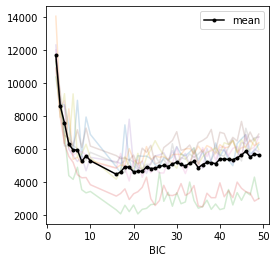

In [19]:
plt.figure(figsize=(4,4))

for cv in np.unique(cv_list):
    plt.plot(n_clust_list[cv_list==cv],bic[cv_list==cv],'-',alpha=0.2)
temp_df = pd.DataFrame({'n_clust_list':n_clust_list,'bic':bic})
temp_df=temp_df.groupby(['n_clust_list']).mean().reset_index(drop=False)
plt.plot(temp_df['n_clust_list'].values,temp_df['bic'].values,'.-k',label = 'mean')
plt.legend()
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_xlabel('BIC')

**FACS unbiased type samples GMM fitting with means initialized**

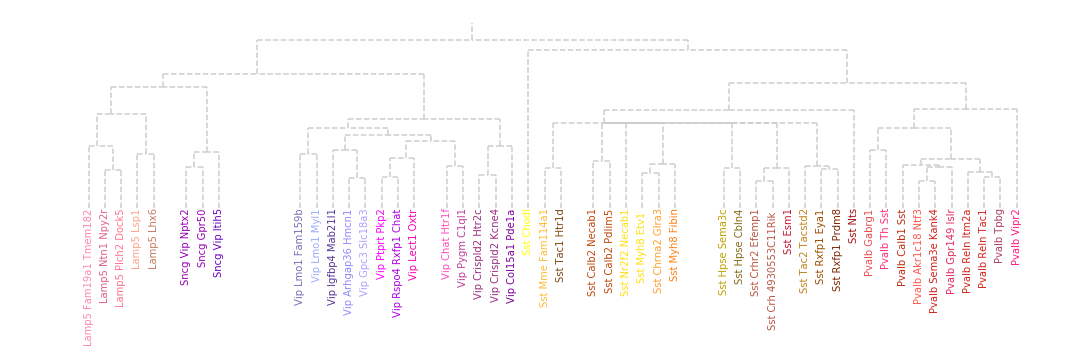

In [2]:
from analysis_tree_helpers import HTree, Node, get_valid_classifications, do_merges
import scipy.io as sio
import pandas as pd

simple_tree_filename = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220_pruned.csv'
htree_df = pd.read_csv(simple_tree_filename)
htree = HTree(htree_df=htree_df)
htree.plot((15,5),fontsize=10,skeletoncol='#CDCDCD',ls='--',txtleafonly=True)
ax = plt.gca()
ax.set_xlim(30,95)
ax.axis('off')
plt.tight_layout()


#Full data matrices
path_ = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/'
D = sio.loadmat(path_+'result/FACS_tests/eq_samples_ld_3_bs_200_ns_50_rs_0_se_500_ne_1500_ri_0100_ft-summary.mat',squeeze_me=True)
O = sio.loadmat(path_+'raw/Mouse-V1-ALM-20180520_GABA_patchseq_v1.mat',squeeze_me=True)
L = htree.get_mergeseq()

def get_cluster_means(lbl,z):
    unique_lbl = np.unique(lbl)
    z_means = np.empty(shape=(unique_lbl.size,z.shape[1]))
    for i,l in enumerate(unique_lbl):
        z_means[i,:] = np.mean(z[lbl==l,:])
    return z_means

In [4]:
# load fitted gmm model from file
from analysis_denovo_script import set_paths
from sklearn import mixture
import scipy.io as sio
import pickle 

#Representations
fiton='zT'
n_cvfolds = 1

#Load all CV sets 
X_train = []
lbl_train= []
XT = []
XE = []
for cvfold in range(n_cvfolds):
        
    CV = D.copy()
    X_train.append(CV[fiton][CV['train_ind'],:])
    lbl_train.append(O['cluster'][CV['train_ind']])

    XT.append(CV['zT'])

In [5]:
n_cvfolds = 1
n_init = 1
max_iter = int(1e4)
tol = 1e-6

n_clust_list = []
cv_list = []
bic = []

for cv in range(0,n_cvfolds):

    for n in range(len(L)):
        merged_sample_labels = do_merges(labels=lbl_train[cv], list_changes=L, n_merges=n)
        cluster_means = get_cluster_means(lbl=merged_sample_labels,z=X_train[cv])
        n_components = cluster_means.shape[0]
        
        gmm = mixture.GaussianMixture(n_components=n_components,
                            covariance_type='full',reg_covar=1e-04,
                            tol=tol,max_iter=max_iter,n_init=n_init,
                            means_init=cluster_means,
                            random_state=None,
                            warm_start=False,
                            verbose=0)
        gmm.fit(X_train[cv])
        bic_val = gmm.bic(X_train[cv])
        print('cv = {:2d} n_comp = {:3d} bic = {:f}'.format(cv,n_components,bic_val))
        n_clust_list.append(n_components)
        cv_list.append(cv)
        bic.append(bic_val)
    
#print('Avg {} component model BIC over cvfolds: {:.2f}'.format(best_n_components,np.mean(bic)))

cv =  0 n_comp =  47 bic = 19522.941131
cv =  0 n_comp =  46 bic = 19552.781331
cv =  0 n_comp =  45 bic = 19096.583477
cv =  0 n_comp =  44 bic = 19187.305235
cv =  0 n_comp =  43 bic = 19352.660670
cv =  0 n_comp =  42 bic = 19394.288866
cv =  0 n_comp =  41 bic = 19579.326097
cv =  0 n_comp =  40 bic = 19299.839520
cv =  0 n_comp =  39 bic = 19248.626492
cv =  0 n_comp =  38 bic = 19359.289945
cv =  0 n_comp =  37 bic = 19288.421593
cv =  0 n_comp =  36 bic = 19274.904309
cv =  0 n_comp =  35 bic = 19046.992345
cv =  0 n_comp =  34 bic = 19682.317969
cv =  0 n_comp =  33 bic = 19080.246486
cv =  0 n_comp =  33 bic = 19290.359634
cv =  0 n_comp =  32 bic = 18912.874288
cv =  0 n_comp =  31 bic = 19445.634858
cv =  0 n_comp =  30 bic = 19379.924196
cv =  0 n_comp =  29 bic = 19315.054077
cv =  0 n_comp =  28 bic = 19294.340396
cv =  0 n_comp =  27 bic = 19352.587631
cv =  0 n_comp =  26 bic = 19248.617182
cv =  0 n_comp =  25 bic = 19267.520332
cv =  0 n_comp =  24 bic = 19302.637368


In [6]:
cv_list = np.array(cv_list)
n_clust_list = np.array(n_clust_list)
bic = np.array(bic)

Text(0.5, 0, 'BIC')

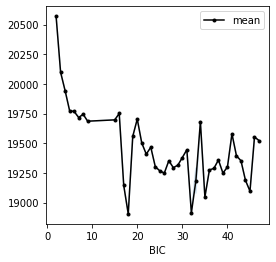

In [7]:
plt.figure(figsize=(4,4))

for cv in np.unique(cv_list):
    plt.plot(n_clust_list[cv_list==cv],bic[cv_list==cv],'-',alpha=0.2)
temp_df = pd.DataFrame({'n_clust_list':n_clust_list,'bic':bic})
temp_df=temp_df.groupby(['n_clust_list']).mean().reset_index(drop=False)
plt.plot(temp_df['n_clust_list'].values,temp_df['bic'].values,'.-k',label = 'mean')
plt.legend()
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_xlabel('BIC')

   n_components  cv           bic           aic  converged
8            18   0  19801.993395  18764.278257          1
   n_components  cv           bic           aic  converged
7            27   0  32372.565042  30658.700908          1


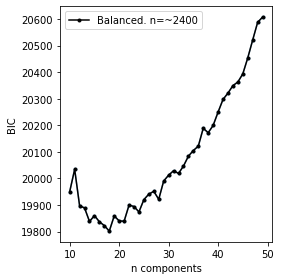

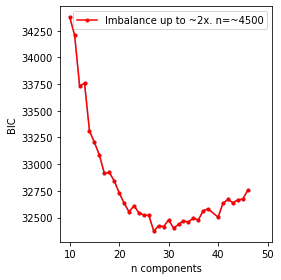

In [10]:
path_ = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/FACS_tests/denovo_clustering_facs_balanced/'
Da = pd.read_csv(path_+'logs_10_20.csv')
Db = pd.read_csv(path_+'logs_20_30.csv')
Dc = pd.read_csv(path_+'logs_30_40.csv')
Dd = pd.read_csv(path_+'logs_40_50.csv')
D = pd.concat([Da,Db,Dc,Dd])

X_mean = D.groupby('n_components').mean()[['bic']]
X_sd = D.groupby('n_components').std()[['bic']]
best_n_components = X_mean['bic'].idxmin()
plt.figure(figsize=(4,4))
cv=0

Dd = D[D['cv']==cv]
plt.plot(Dd['n_components'],Dd['bic'],'.-',alpha=0.5)
print(Dd.loc[Dd['bic']==Dd['bic'].min()])

plt.plot(X_mean.index.values,X_mean['bic'].values,'.-',c='k',label='Balanced. n=~2400')
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
#ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.legend()
plt.tight_layout()

#-----------------------------With more data, allowing imbalances up to ~2 fold

path_ = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/FACS_tests/denovo_clustering_facs_imbalanced/'
Da = pd.read_csv(path_+'logs_10_20.csv')
Db = pd.read_csv(path_+'logs_20_30.csv')
Dc = pd.read_csv(path_+'logs_30_40.csv')
Dd = pd.read_csv(path_+'logs_40_50.csv')
D = pd.concat([Da,Db,Dc,Dd])

X_mean = D.groupby('n_components').mean()[['bic']]
X_sd = D.groupby('n_components').std()[['bic']]
best_n_components = X_mean['bic'].idxmin()

plt.figure(figsize=(4,4))
cv=0

Dd = D[D['cv']==cv]
plt.plot(Dd['n_components'],Dd['bic'],'.-',alpha=0.5)
print(Dd.loc[Dd['bic']==Dd['bic'].min()])
plt.plot(X_mean.index.values,X_mean['bic'].values,'.-',c='r',label='Imbalance up to ~2x. n=~4500')
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
#ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.legend()
plt.tight_layout()

    n_components  cv           bic          aic  converged
13            28   0  50199.423904  46459.50477          1


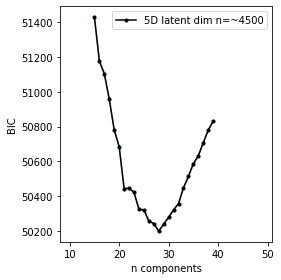

In [3]:
path_ = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/FACS_tests/denovo_clustering_ldtest/'
D = []
for (i,j) in zip(range(15,36,5),range(20,41,5)):
    D.append(pd.read_csv(path_+'logs_{}_{}.csv'.format(i,j)))

D = pd.concat(D)
D = D[D['cv'].isin([0,1,2,3,4])].reset_index(drop=True)

X_mean = D.groupby('n_components').mean()[['bic']]
X_sd = D.groupby('n_components').std()[['bic']]
best_n_components = X_mean['bic'].idxmin()
plt.figure(figsize=(4,4))
cv=0

Dd = D[D['cv']==cv]
plt.plot(Dd['n_components'],Dd['bic'],'.-',alpha=0.5)
print(Dd.loc[Dd['bic']==Dd['bic'].min()])

plt.plot(X_mean.index.values,X_mean['bic'].values,'.-',c='k',label='5D latent dim n=~4500')
ax = plt.gca()
ax.set_xlabel('n components')
ax.set_ylabel('BIC')
#ax.set_ylim(1000,5600)
ax.set_xlim(8,51)
ax.set_xticks(np.arange(10,51,10))
plt.legend()
plt.tight_layout()

In [16]:
D

,n_components,cv,bic,aic,converged
0,10,0,34685.842903,34056.870014,1
1,11,0,34625.794511,33933.289007,1
2,12,0,34647.307157,33891.269038,1
3,13,0,34641.755172,33822.184439,1
4,14,0,34633.835595,33750.732247,1
...,...,...,...,...,...
195,45,4,35792.537773,32935.501753,1
196,46,4,35832.993533,32912.326421,1
197,47,4,35882.011235,32897.713032,1
198,48,4,35933.226362,32885.297067,1


**Representations**

In [1]:
%matplotlib qt5

In [2]:
import os
import fnmatch
import pprint

import numpy as np
import scipy.io as sio
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import HTML

def scatter3(X,col,xlims=(3,3),ylims=(3,3),zlims=(3,3)):
    sns.set_style("whitegrid")
    plt.ion()
    fig = plt.figure(figsize=(4,4))    
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X[:,0], X[:,1], X[:,2],s=1,alpha=1,c=col)

    ax.set_xticks([])
    ax.set_zticks([])
    ax.set_yticks([])
    
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_zlabel('')
    
    ax.set_xlim(xlims[0],xlims[1])
    ax.set_ylim(ylims[0],ylims[1])
    ax.set_zlim(zlims[0],zlims[1])

    plt.axis('on')
    ax.set_frame_on(False)
    plt.tight_layout()
    return ax,sc

In [3]:
dir_pth={}
raw_data_pth = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
dir_pth['result'] = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/result/TE_Patchseq_Bioarxiv/'

csTE='0-0'
aE = '1-0'
cv=1

#Full data matrices
O = sio.loadmat(raw_data_pth+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)
D = sio.loadmat(dir_pth['result']+'v2_aT_1-0_aE_'+str(aE)+'_aM_'+str(aE)+'_cs_'+str(csTE)+'_ld_3_bs_200_se_500_ne_1500_cv_'+str(cv)+'_ri_0500_ft-summary.mat',squeeze_me=True)

xlims=(-3,3)
ylims=(-3,3)
zlims=(-3,3)
padval=-210
fontsizeval=13

In [4]:
ax,sc = scatter3(D['zT'],O['cluster_color'],xlims,ylims,zlims)
ax.set_title(r'$z_t$, $\lambda_{te}$='+csTE.replace('-','.'),pad=padval,fontsize=fontsizeval)
ax.view_init(elev=-31.0, azim=-47)
fig = plt.gcf()

def update(i):
    ax.view_init(elev=10., azim=i)
    fig.canvas.draw()
    fig.canvas.flush_events()
    return


In [13]:
ax,sc = scatter3(D['zE'],O['cluster_color'],xlims,ylims,zlims)
ax.set_title(r'$z_e$, $\lambda_{te}$='+csTE.replace('-','.'),pad=padval,fontsize=fontsizeval)
ax.view_init(elev=-31.0, azim=-47)
fig = plt.gcf()

def update(i):
    ax.view_init(elev=10., azim=i)
    fig.canvas.draw()
    fig.canvas.flush_events()
    return


In [7]:
path_ = '/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/'
D = sio.loadmat(path_+'result/FACS_tests/eq_samples_ld_3_bs_200_ns_50_rs_0_se_500_ne_1500_ri_0100_ft-summary.mat',squeeze_me=True)
O = sio.loadmat(path_+'raw/Mouse-V1-ALM-20180520_GABA_patchseq_v1.mat',squeeze_me=True)
xlims=(-3,3)
ylims=(-3,3)
zlims=(-3,3)
padval=-210
fontsizeval=13

In [11]:
O['cluster_color'][D['train_ind']].shape

(2350,)

In [45]:
%matplotlib qt5

In [16]:
ax,sc = scatter3(D['zT'][D['train_ind'],:],O['cluster_color'][D['train_ind']],xlims,ylims,zlims)
ax.set_title(r'$z_t$ FACS',pad=padval,fontsize=fontsizeval)
ax.view_init(elev=-31.0, azim=-47)
fig = plt.gcf()

def update(i):
    ax.view_init(elev=10., azim=i)
    fig.canvas.draw()
    fig.canvas.flush_events()
    return

In [42]:
a = pd.read_csv('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/FACS_tests/logs/eq_samples_ld_3_bs_200_ns_50_rs_0_se_500_ne_1500_ri_0.csv')
b = pd.read_csv('/home/rohan/Dropbox/AllenInstitute/CellTypes/dat/result/FACS_tests/logs/eq_samples_ld_3_bs_200_ns_50_rs_0_se_500_ne_1500_ri_0100_ft.csv')

In [46]:
plt.plot(a['train_epoch'],a['train_mse_T'],'-')
plt.plot(b['train_epoch']+a['train_epoch'].values[-1],b['train_mse_T'],'-')
ax = plt.gca()